In [63]:
#! usr/bin/env python3
import praw
import pandas as pd
from datetime import datetime as dt
import time, calendar
import psycopg2
import time
import pymongo
starttime=time.time()
import matplotlib.pyplot as plt
# import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import scipy.stats as stats
from scipy.stats import linregress




In [10]:
# Write file to dataFrame
filepath = "df_reddit.csv"

dataframereddit = pd.read_csv(filepath, sep = '\t', encoding ='utf-8', parse_dates=['Created'])
dataframereddit


,Unnamed: 0,ID,Title,Body,Score,URL,Comments,Created
0,0,ejl023,Perfect timing,NaN,17413,https://v.redd.it/ayzsxc2tfm841,315,2020-01-04 04:14:06
1,1,ejk48x,TIL Research shows that children as young as 4...,NaN,23802,https://news.yale.edu/2018/07/23/even-4-year-o...,1116,2020-01-04 03:14:08
2,2,ejk3qx,In The Lego Movie (2014) Benny the spaceman ha...,NaN,18413,https://i.redd.it/1yf0ofvx4m841.jpg,264,2020-01-04 03:13:11
3,3,ejjmjr,Recommendations!,NaN,24502,https://i.redd.it/j6e4ge34zl841.jpg,101,2020-01-04 02:40:32
4,4,ejkcib,New Years photobomb!,NaN,11507,https://i.redd.it/1dashplv7m841.jpg,173,2020-01-04 03:29:40
...,...,...,...,...,...,...,...,...
6268834,7172467,el49up,"umm, oopsie!",NaN,344,https://i.redd.it/rldx31cqi9941.jpg,11,2020-01-07 09:51:27
6268835,7172468,elbkks,So do you want the green meth or the blue meth?,NaN,43,https://i.redd.it/2wuua1bfzc941.jpg,4,2020-01-07 21:30:22
6268836,7172469,elb5dc,Ah yes happened yesterday,NaN,45,https://i.redd.it/i82z1sx7sc941.jpg,1,2020-01-07 20:49:58
6268837,7172471,elbngo,Me Trying to sleep,NaN,40,https://i.redd.it/lflndbnq0d941.png,1,2020-01-07 21:37:44


In [64]:
# Cleaning work
work = dataframereddit.copy()
work.drop(['Body', 'URL', 'Unnamed: 0', 'Title'], axis=1, inplace = True)
work.dropna(axis=0, how='any', thresh=None, subset=['Score', 'Comments', 'Created'] , inplace=True)
work


,ID,Score,Comments,Created
0,ejl023,17413,315,2020-01-04 04:14:06
1,ejk48x,23802,1116,2020-01-04 03:14:08
2,ejk3qx,18413,264,2020-01-04 03:13:11
3,ejjmjr,24502,101,2020-01-04 02:40:32
4,ejkcib,11507,173,2020-01-04 03:29:40
...,...,...,...,...
6268834,el49up,344,11,2020-01-07 09:51:27
6268835,elbkks,43,4,2020-01-07 21:30:22
6268836,elb5dc,45,1,2020-01-07 20:49:58
6268837,elbngo,40,1,2020-01-07 21:37:44


In [65]:
# sort = df.sort_values(by=['col1']) 
work.drop_duplicates(subset = 'ID', keep = 'last', inplace = True)
work

,ID,Score,Comments,Created
384,ejh7ro,4205,121,2020-01-03 23:52:23
2088,ejhkfr,1110,11,2020-01-04 00:16:39
3263,eji50e,576,13,2020-01-04 00:56:52
3455,ejm307,163,5,2020-01-04 05:29:20
3488,ej5zei,12760,142,2020-01-03 07:04:51
...,...,...,...,...
6268834,el49up,344,11,2020-01-07 09:51:27
6268835,elbkks,43,4,2020-01-07 21:30:22
6268836,elb5dc,45,1,2020-01-07 20:49:58
6268837,elbngo,40,1,2020-01-07 21:37:44


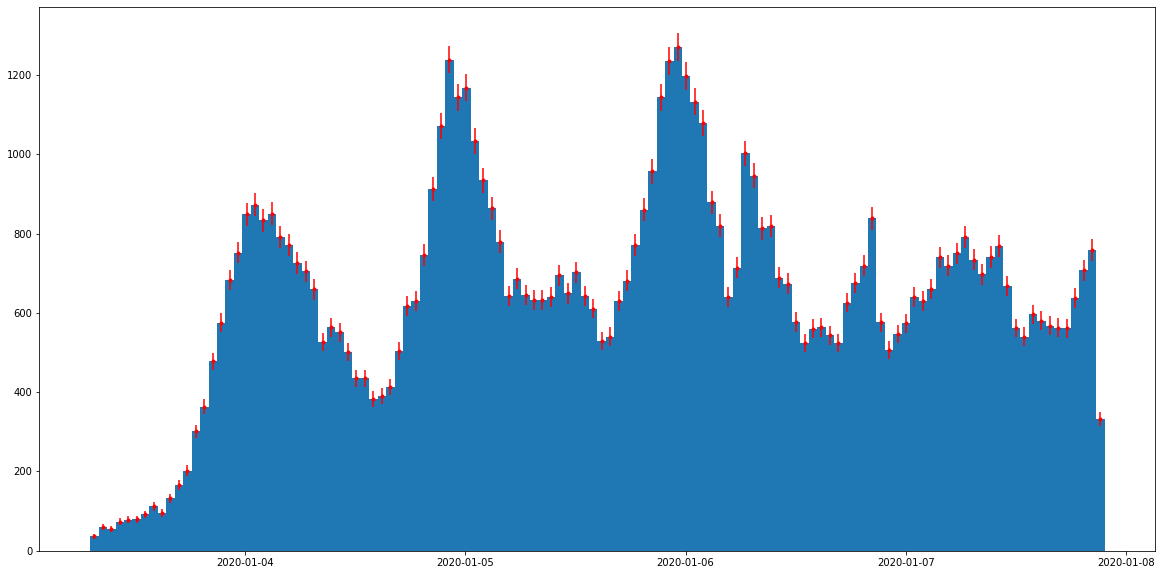

TypeError: 'str' object is not callable

<Figure size 1440x720 with 0 Axes>

In [66]:
# Here we show a histogram by day 
work.sort_values(by=['Score'], ascending = False, inplace = True)
data = work['Created']
plt.figure(figsize=([20,10]))
# work['Created'].hist(bins = 30)

entries, edges, _ = plt.hist(data, bins=120)


# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])

# draw errorbars, use the sqrt error. You can use what you want there
# poissonian 1 sigma intervals would make more sense
plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='r.')

plt.show()

plt.figure(figsize = [20,10])
plt.xlabel('Dates of scraped days (one bin per hour)')
plt.ylabel('Count of comments')


,Comments
6263621,101
578201,101
6264642,101
1258718,101
2170826,101
...,...
573235,15918
1270255,20735
226863,21529
452269,31235


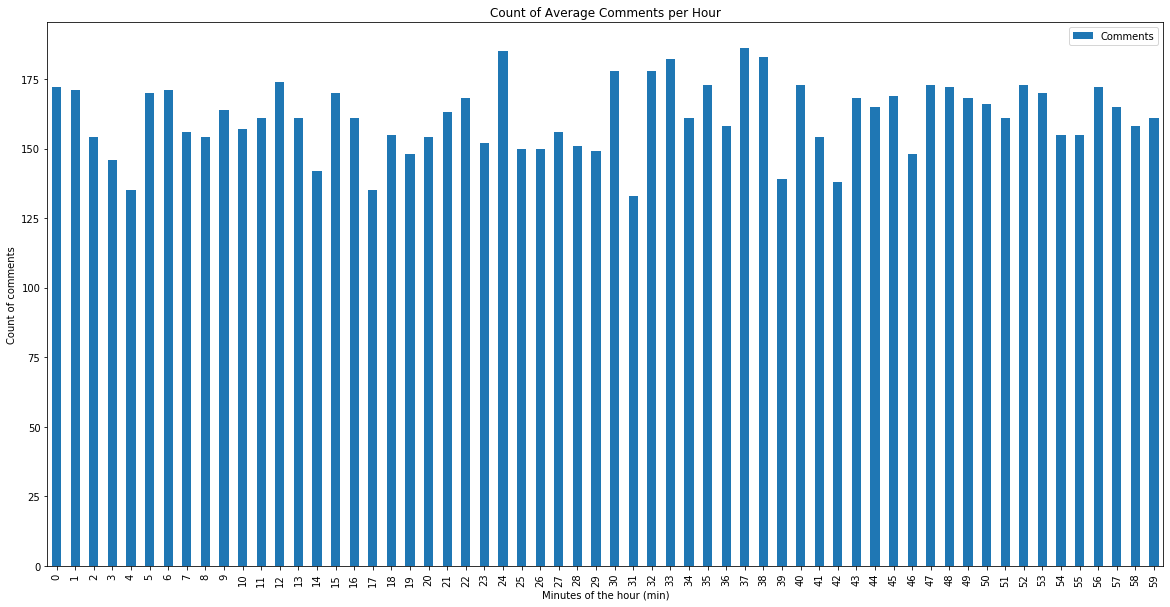

In [41]:
# Comments analysis
commentwork = work.copy()

commentwork = commentwork[commentwork['Comments'] > 100]
# x = work['Score']
commentwork['Created'] = pd.to_datetime(work['Created'], errors='coerce')


commentwork.drop(['ID', 'Score', 'Created'], axis=1, inplace = True)


commentwork.groupby(work["Created"].dt.minute).count().plot( kind="bar", figsize = [20,10], 
                                                            title = 'Count of Average Comments per Hour')

plt.xlabel('Minutes of the hour (min)')
plt.ylabel('Count of comments')
commentwork.sort_values(by=['Comments'], inplace = True)

commentwork

TypeError: 'str' object is not callable

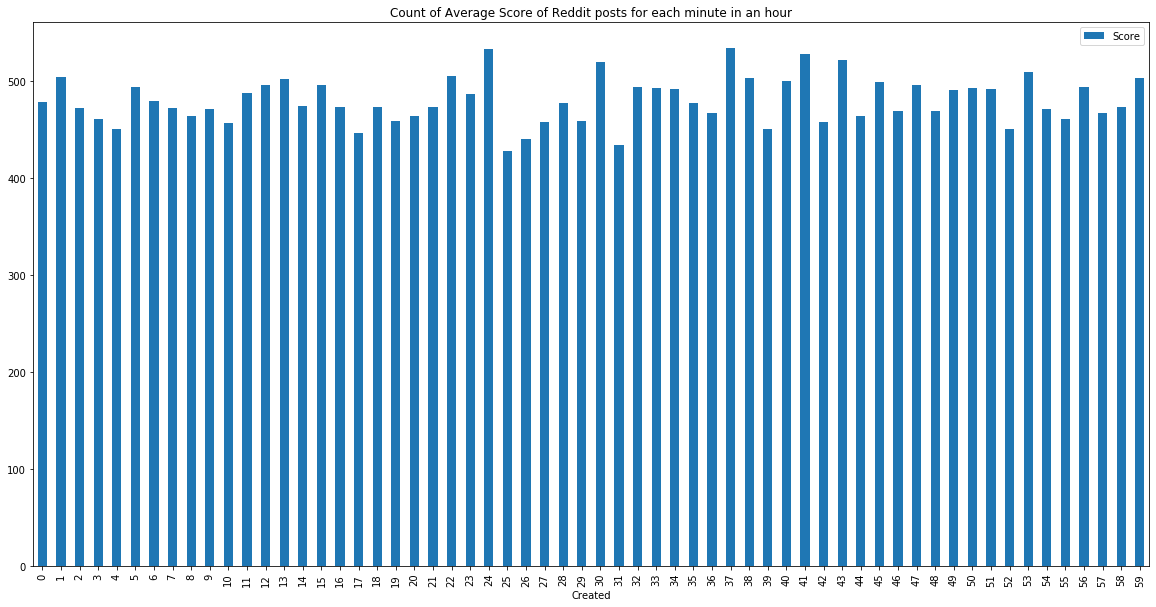

In [53]:
# Score Analysis
scorework = work.copy()

scorework = scorework[scorework['Score'] > 750]
# x = work['Score']
scorework['Created'] = pd.to_datetime(work['Created'], errors='coerce')

scorework.drop(['ID', 'Comments', 'Created'], axis=1, inplace = True)
# work.drop[['']]
scorework.groupby(work["Created"].dt.minute).count().plot( kind="bar", 
                                                          figsize = [20,10], 
                                                          title = 'Count of Average Score of Reddit posts for each minute in an hour')


# plt.xlabel("Minute of hour (min)")



# plt.ylabel('Average score')

scorework

In [283]:
study_df = work.copy()
study_df['300+ comments?'] = study_df['Comments'].apply(lambda x: 1 if x > 300 else 0)
# df['Normal'] = df.Speed.apply(lambda x: 1 if x == "Normal" else 0)

df_high_comments = study_df[study_df['Comments'] > 300] 
df_high_comments

,ID,Score,Comments,Created,300+ comments?
3111129,ek33p5,151464,1069,2020-01-05 05:50:50,1
4887766,ekehvg,146999,2463,2020-01-05 23:39:27,1
4797052,ekcm64,138583,3878,2020-01-05 20:48:52,1
2177414,ejwxed,133345,7105,2020-01-04 21:59:08,1
6266062,el1g2a,125388,1690,2020-01-07 06:23:25,1
...,...,...,...,...,...
2490116,ekc0yj,99,752,2020-01-05 19:44:43,1
4887924,ekrkol,97,2677,2020-01-06 17:04:16,1
805336,ejxydi,94,644,2020-01-04 23:30:25,1
3002887,ekgc53,93,366,2020-01-06 01:51:51,1


In [263]:
df_high_score = study_df[study_df['Score']>5000]
# Is there a significant relationship between high score and high amount of comments
stats.ttest_rel(df_high_score.Score.sample(665), df_high_comments.Comments)


Ttest_relResult(statistic=21.449643161029304, pvalue=5.997067404093111e-78)

,ID,Score,Comments,Created,300+ comments?
3111129,ek33p5,151464,1069,2020-01-05 05:50:50,1
4887766,ekehvg,146999,2463,2020-01-05 23:39:27,1
4797052,ekcm64,138583,3878,2020-01-05 20:48:52,1
2177414,ejwxed,133345,7105,2020-01-04 21:59:08,1
6266062,el1g2a,125388,1690,2020-01-07 06:23:25,1


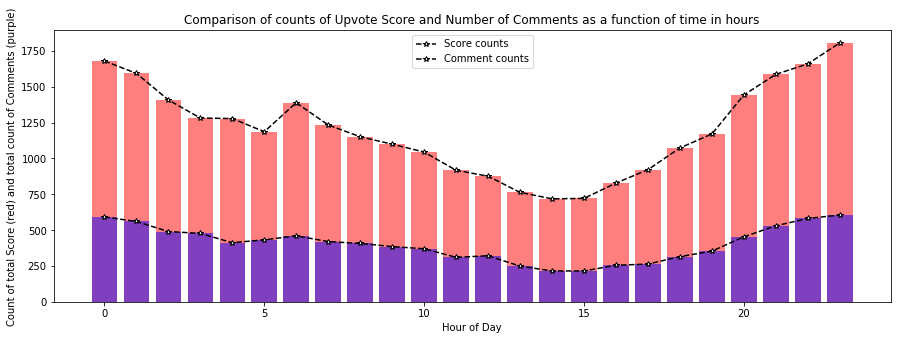

In [32]:
# df_high_score.groupby(df_high_score["Created"].dt.hour).count().plot( kind="bar")
# commentwork.groupby(work["Created"].dt.hour).count().plot( kind="bar", figsize = [20,10], stacked = True)
# scorework.groupby(work["Created"].dt.hour).count().plot( kind="bar", figsize = [20,10], stacked = True)


test_df = commentwork.groupby(work["Created"].dt.hour).count()
test_df['score']= scorework.groupby(work["Created"].dt.hour).count()
test_df['Created'] = list(range(0,24))
fig, ax = plt.subplots(figsize=([15,5]))
plt.plot(test_df.Created, test_df.score, color = 'black', alpha = 1, label = 'Score counts', linestyle='dashed', marker = '*', markerfacecolor='White')
plt.plot(test_df.Created, test_df.Comments,color = 'black',alpha = 1, label = 'Comment counts', linestyle='dashed', marker = '*', markerfacecolor = 'White')
rects1 = ax.bar(test_df.Created, test_df.score, color='r', alpha = .5)
rects2 = ax.bar(test_df.Created, test_df.Comments, color = 'b', alpha= .5)
# plt.figur(figsize=([40,10]))

ax.set_xlabel('Hour of Day')
ax.set_ylabel('Count of total Score (red) and total count of Comments (purple)')
ax.legend()
ax.set_title('Comparison of counts of Upvote Score and Number of Comments as a function of time in hours')
plt.show()


In [335]:
# Analysis of the score count and comment count by date time
stats.ttest_ind(scorework.groupby(work["Created"].dt.hour).count(), commentwork.groupby(work["Created"].dt.hour).count())

Ttest_indResult(statistic=array([11.4070408]), pvalue=array([5.25516666e-15]))

In [303]:
print(scorework.groupby(work["Created"].dt.hour).count())
print(commentwork.groupby(work["Created"].dt.hour).count())

         Score
Created       
0         1679
1         1593
2         1408
3         1281
4         1278
5         1186
6         1388
7         1233
8         1151
9         1099
10        1044
11         917
12         876
13         763
14         718
15         721
16         828
17         921
18        1073
19        1170
20        1442
21        1586
22        1659
23        1805
         Comments
Created          
0             592
1             560
2             490
3             477
4             412
5             432
6             460
7             420
8             407
9             385
10            370
11            310
12            321
13            249
14            215
15            215
16            255
17            263
18            315
19            353
20            453
21            530
22            581
23            605


In [321]:
work["Created"].dt.hour.count()
scorework.groupby(work["Created"].dt.hour)

In [345]:
commentwork.groupby(work["Created"].dt.hour).count()

,Comments
Created,
0,592
1,560
2,490
3,477
4,412
5,432
6,460
7,420
8,407


In [394]:

# Levene test's for homogeneity of variance. based on this result, our distributions have homogeneity of variance. 
# LeveneResult(statistic=17.134951278114134, pvalue=0.0001468753110108723)

# Test to see if the distributions of comments and scores are distributed the same way and check for correlation. Based on these results, 

linregress(test_df.Comments, test_df.score)


LinregressResult(slope=2.6129130003640153, intercept=148.0054702699988, rvalue=0.9781518587229636, pvalue=1.6865157215254291e-16, stderr=0.11839800556581989)

In [396]:
stats.levene(test_df.Comments, test_df.score)

LeveneResult(statistic=17.134951278114134, pvalue=0.0001468753110108723)